In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [15]:
hsg = pd.read_csv (r"C:\Users\adm\STAT3013\HSG Historical Data.csv")

In [17]:
hsg = hsg.sort_index(ascending=False)
hsg = hsg.reset_index(drop=True)

# Modify data
# Remove the '%' sign and convert to float
hsg['Change %'] = hsg['Change %'].replace('%', '', regex=True).astype(float)

# Convert the percentage values to decimals (divide by 100)
hsg['Change %'] = hsg['Change %'] / 100

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    hsg[col] = hsg[col].astype(str).str.replace(',', '').astype(float)

hsg['Date'] = pd.to_datetime(hsg['Date'])
hsg

missing_values = hsg.isnull().sum()
hsg = hsg.dropna()

# Function to convert 'K' values to integers
def convert_volume(value):
    if pd.isnull(value):
        return np.nan  # Handle missing values
    elif 'K' in value:
        return float(value.replace('K', '')) * 1000
    elif 'M' in value:
        return float(value.replace('M', '')) * 1000000
    elif 'B' in value:
        return float(value.replace('B', '')) * 1000000000
    else:
        return float(value)

# Apply the function to the "Volume" column
hsg['Vol.'] = hsg['Vol.'].apply(convert_volume)

# Display the cleaned DataFrame
hsg.drop('Date', axis=1).describe()

,Price,Open,High,Low,Vol.,Change %
count,1207.000000,1207.000000,1207.000000,1207.000000,1.207000e+03,1207.000000
mean,19056.569843,19078.309528,19451.815327,18718.237780,1.275624e+07,0.001566
std,8558.418366,8586.476531,8707.452217,8446.503241,5.922639e+06,0.031350
min,3282.800000,3246.800000,3463.200000,3145.700000,2.100000e+06,-0.082900
25%,13366.600000,13330.400000,13636.400000,13018.750000,8.430000e+06,-0.015500
50%,18512.800000,18525.400000,19000.000000,18123.100000,1.186000e+07,0.000000
75%,22850.000000,22878.800000,23169.850000,22526.750000,1.583500e+07,0.018400
max,41541.700000,41750.000000,42750.000000,41333.300000,4.365000e+07,0.070000


In [19]:
# Tính sai phân
hsg['Price_diff'] = hsg['Price'].diff()

# Loại bỏ các giá trị NaN hoặc Inf trong 'Price_diff'
hsg = hsg.dropna(subset=['Price_diff'])  # Loại bỏ NaN
hsg = hsg[~hsg['Price_diff'].isin([np.inf, -np.inf])]  # Loại bỏ Inf và -Inf

# Kiểm tra xem có giá trị NaN hoặc Inf trong 'Price_diff' hay không
print("Checking for missing or infinite values in Price_diff:")
print(f"NaN values: {hsg['Price_diff'].isnull().sum()}")
print(f"Inf values: {np.isinf(hsg['Price_diff']).sum()}")

# Function to check stationarity using the Augmented Dickey-Fuller (ADF) test
def check_stationarity(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("The series is stationary (p-value < 0.05).")
    else:
        print("The series is not stationary (p-value >= 0.05).")

# Check the stationarity of 'Price_diff'
print("\nChecking stationarity of Price_diff:")
check_stationarity(hsg['Price_diff'])

# Use 'Price_diff' as the target series for modeling
target_series = hsg['Price_diff']

# Clean the target series by removing NaN and Inf values
target_series = target_series.dropna()
target_series = target_series[~target_series.isin([np.inf, -np.inf])]

# Check for valid data in the target series
print("\nAfter cleaning target series:")
print(f"NaN values: {target_series.isnull().sum()}")
print(f"Inf values: {np.isinf(target_series).sum()}")

# Split the data into training (80%) and testing (20%) sets
train_size = int(0.8 * len(target_series))
train_data = target_series[:train_size]
test_data = target_series[train_size:]

# Print sizes of training and testing data
print("\nTraining Data Size:", len(train_data))
print("Testing Data Size:", len(test_data))



Checking for missing or infinite values in Price_diff:
NaN values: 0
Inf values: 0

Checking stationarity of Price_diff:
ADF Statistic: -7.568217450027237
p-value: 2.8875373001434544e-11
The series is stationary (p-value < 0.05).

After cleaning target series:
NaN values: 0
Inf values: 0

Training Data Size: 964
Testing Data Size: 242


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=15129.139, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=15128.762, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=15126.531, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=15126.506, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=15128.506, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=15128.531, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=15130.505, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=15128.024, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.443 seconds

Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  964
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -7561.253
Date:                Mon, 18 Nov 2024   AIC                          15126.506
Time:       

C:\Users\adm\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\adm\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


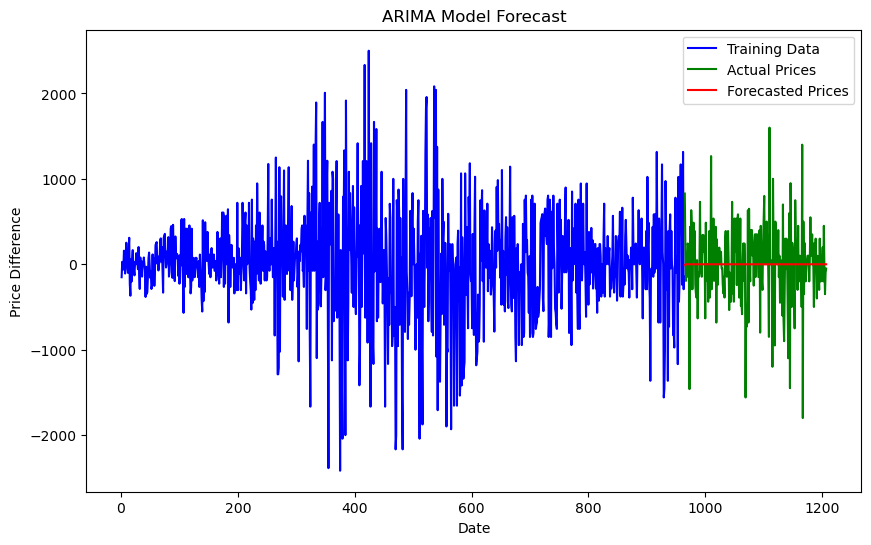


Forecasted vs Actual Prices:
      Actual  Forecasted
965    828.2         0.0
966    194.9         0.0
967   -194.9         0.0
968     97.5         0.0
969   -146.2         0.0
...      ...         ...
1203   450.0         0.0
1204   -50.0         0.0
1205  -350.0         0.0
1206  -100.0         NaN
1207   -50.0         NaN

[242 rows x 2 columns]


In [21]:
# Fit an ARIMA model using auto_arima to find optimal parameters
model = auto_arima(train_data, seasonal=False, stepwise=True, trace=True)

# Forecast values for the testing period
forecast = model.predict(n_periods=len(test_data))

# Print result of the model
print("\nModel Summary:")
print(model.summary())


# Evaluate the model's performance using Mean Squared Error (MSE)
mse = mean_squared_error(test_data, forecast)
print("\nMean Squared Error:", mse)

# Vẽ biểu đồ dự báo và giá trị thực tế
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Actual Prices', color='green')
plt.plot(test_data.index, forecast, label='Forecasted Prices', color='red')
plt.legend()
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.show()

# Lưu kết quả dự báo
forecast_df = pd.DataFrame({'Actual': test_data, 'Forecasted': forecast}, index=test_data.index)
print("\nForecasted vs Actual Prices:")
print(forecast_df)

In [23]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

forecast_diff = model.predict(n_periods=len(test_data))  # Dự báo sai phân (Price_diff)
# Evaluate reconstructed 'Price' series (undo differencing)
last_price = train_data.iloc[-1]  # Get the last price from the training set
forecast_price = last_price + np.cumsum(forecast_diff) # Reconstruct prices by undoing differencing
y_actual = hsg['Price'][train_size:].values # Get actual prices for comparison


# Check if sizes match before calculating evaluation metrics
if len(y_actual) != len(forecast_price):
    print("Dữ liệu thực tế và dự báo không cùng kích thước!")
else:
    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_actual, forecast_price))
    print("RMSE:", rmse)

    mape = mean_absolute_percentage_error(y_actual, forecast_price)
    print("MAPE:", mape, "%")

    mae = mean_absolute_error(y_actual, forecast_price)
    print("MAE:", mae)

    r_squared = r2_score(y_actual, forecast_price)
    print("R-squared (Using sklearn):", r_squared)


RMSE: 22002.541999535857
MAPE: 1.0071036786116592 %
MAE: 21956.28343377083
R-squared (Using sklearn): -237.07153613029158


C:\Users\adm\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\adm\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
